## Analyse exploratoire et création d'un rapport détaillé des données immobilières avec Python Pandas et ProfileReport

#### Introduction

Nous allons une analyse exploratrice de données immobilère.

Tout d'abord nous allons:

* Réalisation d'un audit des données
* Nettoyer les données
* Créer la colonne Nom de commune en fonction du code postal en réalisant une fusion des données  télécharger sur datagouv 
* Créer la colonne département avec une fonction.

Ensuite nous allons utiliser pandas profiling, une librairie qui génère un rapport au format HTML.

Dans ce rapport nous y retrouvons, organisé de manière séquentielle (ou via le menu du haut) :

* Une synthèse permettant de trouver les : données manquantes, cardinalité.
* Des informations de bases comme: Le nombre de colonnes/lignes, les données manquantes ou en doublon, la mémoire occupée, etc.

Par colonne:

* Des statistiques quantiles: valeur minimale, Q1, médiane, Q3, maximum, plage, plage interquartile
* Des Statistiques descriptives telles que la moyenne, médiane, écart-type, somme, écart absolu médian, coefficient de variation, kurtosis, asymétrie
* Inférence de type : Les types des données réelles constatés dans le jeu de données (chaînes catégorielles, numériques, etc.)
* Les Valeurs les plus fréquentes
* Distribution des valeurs (Histogrammes)
* Une analyse détaillée des corrélations mettant en évidence des variables hautement corrélées, matrices Spearman, Pearson et Kendall 
* Matrice des valeurs manquantes, comptage, carte thermique et dendrogramme des valeurs manquantes






### Importation des librairies Python
Importons dans un premier temps l'ensemble des librairies Python :

In [47]:
import pandas as pd
import numpy as np
#from pandas_profiling import ProfileReport
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

## Importation des données 

In [23]:
df= pd.read_excel('excel/bdd_immo.xlsx')

### Visualisation des données

Les 5 premières lignes

In [24]:
df.head()

,type,nature,superficie,jardin,garage,secteur,CP,prix estimation,prix vente,date annonce,date vente,Diag therm
0,T7,maison,60,1793,NaN,nord,87100,58023,48000,2013-05-26,2013-09-03,C
1,T3,app,60,1775,oui,nord,87100,58136,55000,2013-10-19,2015-05-11,C
2,T3,app,60,1764,NaN,nord,87100,58384,54000,2014-02-22,2015-01-07,D
3,T7,maison,61,1762,oui,ouest,87280,60117,50000,2013-08-10,2013-11-04,C
4,T4,app,61,1759,NaN,nord,19100,60413,47000,2014-06-15,2015-10-16,C


# <a name="C2">P2C3 - Nettoyez votre jeu de données</a>

Il est à présent temps de mettre en pratique tout ce que nous avons vu sur notre jeu de données de transactions bancaires. Plusieurs **erreurs** se sont glissées dans ce jeu de données. Votre mission, si toutefois vous l'acceptez, va être de les **trouver** et de **proposer des solutions** adéquates pour les gérer.

### 1. Erreurs de type

Le premier reflexe devrait être de vérifier que les variables ont bien été importées dans le bon type :

## Informations sur le jeu de données



In [25]:
df.shape

(499, 12)

#### Intitulés des colonnes


In [26]:
df.columns

Index(['type', 'nature', 'superficie', 'jardin', 'garage', 'secteur', 'CP',
       'prix estimation', 'prix vente', 'date annonce', 'date vente',
       'Diag therm'],
      dtype='object')

### Vérifie le types des variables 
Info affiche le tableau contenant les noms de colonne, le nombre de valeurs non nulles et les types de données.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   type             499 non-null    object        
 1   nature           499 non-null    object        
 2   superficie       499 non-null    int64         
 3   jardin           499 non-null    int64         
 4   garage           193 non-null    object        
 5   secteur          499 non-null    object        
 6   CP               499 non-null    int64         
 7   prix estimation  499 non-null    int64         
 8   prix vente       499 non-null    int64         
 9   date annonce     499 non-null    datetime64[ns]
 10  date vente       499 non-null    datetime64[ns]
 11  Diag therm       499 non-null    object        
dtypes: datetime64[ns](2), int64(5), object(5)
memory usage: 46.9+ KB


## Informations sur la valeur nulle
### 2. Valeurs manquantes


In [28]:
df.isnull().sum()

type                 0
nature               0
superficie           0
jardin               0
garage             306
secteur              0
CP                   0
prix estimation      0
prix vente           0
date annonce         0
date vente           0
Diag therm           0
dtype: int64

### Affiche uniquement les variables qui ont des valeurs manquantes

In [29]:
nb_na = df.isnull().sum()
nb_na[nb_na>0]

garage    306
dtype: int64

On observe que notre jeu de données contient 306 valeurs manquantes dans la colonne 'garage'. Regardons les plus en détails :

In [30]:
df.garage.value_counts()

oui    193
Name: garage, dtype: int64

La seule valeur renseigner est oui donc on peut en déduire que les valeurs manquantes peuvent être remplacés par Non

### Remplace les valeurs null par 'non'

In [31]:
df.loc[df['garage'].isnull(), 'garage'] = 'non'

#### Table de fréquence de la colonne garage. verifie si nan bien remplacé
# Occurrence des modalités d'une colonne 

In [32]:
df.garage.value_counts()

non    306
oui    193
Name: garage, dtype: int64

### Création des colonnes département et nom de commune

### Création de la colonne: Nom de commune

Nous allons utiliser la colonne Code postale (CP)

Sur le site de datagouv.fr j'ai téléchargé le fichier csv  **Base officielle des codes postaux**

https://www.data.gouv.fr/fr/datasets/base-officielle-des-codes-postaux/

Description

La base officielle des codes postaux est un jeu de données qui fournit la correspondance entre les codes postaux et les codes INSEE des communes, de France (métropole et DOM), des TOM, ainsi que de MONACO.

Ce jeu de données comprend :

- Le nom de la commune

- Le code INSEE de la commune

- La ligne 5 de l'adresse postale : précision du lieu-dit associé ou du nom de la commune déléguée associée

- Le code postal de la commune

- Le libellé d’acheminement



Chargement du fichier csv

In [33]:
code_postal= pd.read_csv('laposte_hexasmal.csv', sep=';')

In [34]:
code_postal.head()


,Code_commune_INSEE,Nom_commune,Code_postal,Ligne_5,Libellé_d_acheminement,coordonnees_geographiques
0,25615,VILLARS LES BLAMONT,25310,NaN,VILLARS LES BLAMONT,"47.368383721,6.871414913"
1,25619,LES VILLEDIEU,25240,NaN,LES VILLEDIEU,"46.713906258,6.26583065"
2,25622,VILLERS BUZON,25170,NaN,VILLERS BUZON,"47.228558434,5.852186748"
3,25625,VILLERS LA COMBE,25510,NaN,VILLERS LA COMBE,"47.240809828,6.473842387"
4,25627,VILLERS SOUS CHALAMONT,25270,NaN,VILLERS SOUS CHALAMONT,"46.901588322,6.045328224"


In [35]:
code_postal.dtypes

Code_commune_INSEE           object
Nom_commune                  object
Code_postal                   int64
Ligne_5                      object
Libellé_d_acheminement       object
coordonnees_geographiques    object
dtype: object

Renomme la colonne la 'Code_postal'en 'CP' afin d'avoir le même non de colonne pour joindre ce dataframe à notre dataframe de données immobilière

In [36]:
code_postal=code_postal.rename(columns={ 'Code_postal':'CP',
                                 
                                    })

Merge des deux dataframe

In [37]:
import pandas as pd
df = pd.merge(df,code_postal[['CP','Nom_commune']],on='CP', how='left')

### Création colonne 'département'

Création d'une fonction afin de créer une colonne 'département' en fonction de la colonne 'CP'

In [38]:
def dep(x):
    if x[:2]== "19":
        return "Corrèze"
    elif x[:2]== "23":
        return 'Creuse'
    elif x[:2]== "87":
        return 'Haute-vienne'
    elif x[:2]== "24":
        return 'Dordogne'
    elif x[:2]== "33":
        return 'Gironde'
    
#test    
dep('87450')

'Haute-vienne'

#### Changement de type de la varible CP afin d'appliquer la fonction sans message d'erreur

In [39]:
df['CP'] = df['CP'].apply(lambda x: str(x))
print(df['CP'].dtypes) # Can verify to see that CP prints out as an object

object


Applique la fonction 

In [40]:
df['departement']= df['CP'].apply(dep)


Le nom de la commune et le département sont désormais présents dans la dataframe

In [41]:
df

,type,nature,superficie,jardin,garage,secteur,CP,prix estimation,prix vente,date annonce,date vente,Diag therm,Nom_commune,departement
0,T7,maison,60,1793,non,nord,87100,58023,48000,2013-05-26,2013-09-03,C,LIMOGES,Haute-vienne
1,T7,maison,60,1793,non,nord,87100,58023,48000,2013-05-26,2013-09-03,C,LIMOGES,Haute-vienne
2,T3,app,60,1775,oui,nord,87100,58136,55000,2013-10-19,2015-05-11,C,LIMOGES,Haute-vienne
3,T3,app,60,1775,oui,nord,87100,58136,55000,2013-10-19,2015-05-11,C,LIMOGES,Haute-vienne
4,T3,app,60,1764,non,nord,87100,58384,54000,2014-02-22,2015-01-07,D,LIMOGES,Haute-vienne
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,T4,app,179,0,oui,ouest,19360,383360,372000,2013-09-27,2014-05-12,B,COSNAC,Corrèze
1670,T4,app,179,0,oui,ouest,19360,383360,372000,2013-09-27,2014-05-12,B,DAMPNIAT,Corrèze
1671,T3,app,179,0,non,ouest,87000,383580,355000,2013-11-02,2015-04-19,C,LIMOGES,Haute-vienne
1672,T4,app,180,0,non,nord,87100,383797,355000,2013-12-10,2015-01-13,F,LIMOGES,Haute-vienne


## Rapport Pandas-profiling

Un fichier rapport.html est alors généré. Ce rapport complet présente toutes les informations utiles pour commencer à travailler les données.

In [48]:
import pandas_profiling

import matplotlib.pyplot as plt
%matplotlib inline

profile = ProfileReport(df, title='Analyse des données immobilière',
                        dataset={
        "description": "Ce rapport a été généré par Eve Telega",
        "copyright_holder": "Eve Telega",
        "copyright_year": "2023"} ,html={'style':{'full_width':True}})
profile.to_notebook_iframe()# Rapport HTML
#profile.to_widgets()# Affichage adapté à Jupyter

C:\Users\evete\AppData\Local\Temp\ipykernel_1184\2044548114.py:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

##### Exportation du rapport vers un fichier html


In [43]:
profile.to_file("analyse_data_immo.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Après exploration de ce rapport, on observe que la colonne 'Nom_commune' contient 37 valeurs manquantes. Regardons les plus en détails 


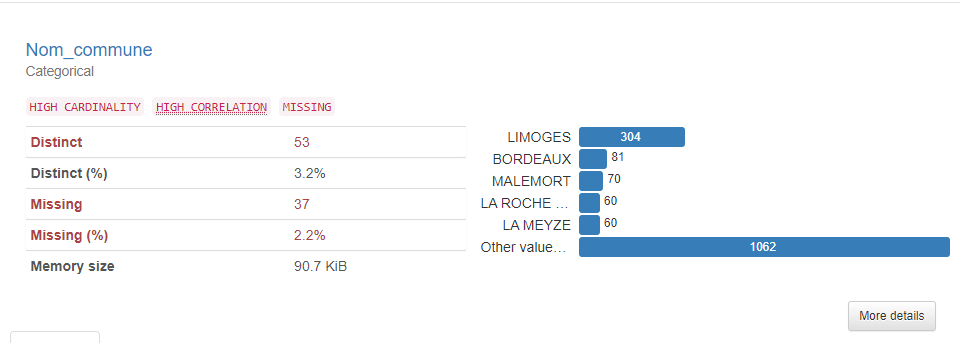

In [44]:
from IPython.display import Image
Image("missing.png")

Le code postale renseigner est 87450 alors que ce code postale n'existe pas. Nous conservons les lignes car le département 87 est la Haute-vienne. 

In [45]:
df.loc[df['Nom_commune'].isnull(),:]

,type,nature,superficie,jardin,garage,secteur,CP,prix estimation,prix vente,date annonce,date vente,Diag therm,Nom_commune,departement
29,T2,app,63,1600,non,nord,87450,63243,55000,2014-04-29,2016-03-14,F,NaN,Haute-vienne
41,T3,app,64,1586,non,nord,87450,65112,57000,2014-01-11,2014-08-30,C,NaN,Haute-vienne
142,T5,app,69,1257,non,nord,87450,80875,70000,2013-08-20,2014-04-19,D,NaN,Haute-vienne
247,T2,app,75,831,non,nord,87450,94406,71000,2014-02-14,2014-12-05,B,NaN,Haute-vienne
298,T5,maison,76,765,non,nord,87450,97527,86000,2013-04-14,2015-02-11,E,NaN,Haute-vienne
380,T4,app,80,562,non,ouest,87450,114066,108000,2014-02-06,2014-12-13,E,NaN,Haute-vienne
443,T2,app,83,440,non,nord,87450,126865,108000,2014-07-26,2016-03-24,C,NaN,Haute-vienne
491,T4,app,87,260,non,sud,87450,135379,100000,2014-05-19,2015-03-31,E,NaN,Haute-vienne
526,T2,app,87,180,non,nord,87450,140175,113000,2014-06-02,2015-05-05,E,NaN,Haute-vienne
735,T2,app,100,0,oui,nord,87450,169100,163000,2013-11-30,2014-05-20,E,NaN,Haute-vienne


Corrélation entre les variables.

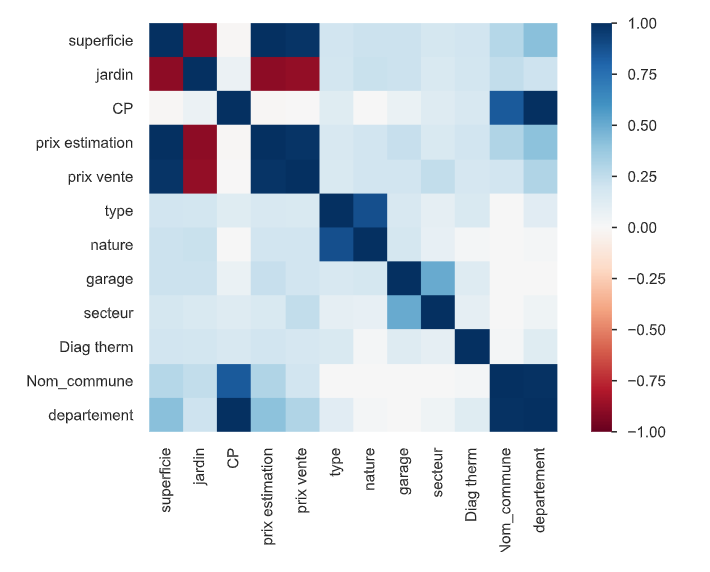

In [46]:
from IPython.display import Image
Image("corr.png")

En toute logique, il a une forte corrélation entre le prix de vente et la superficie et le prix estimé.